In [1]:
# Import necessary libraries for wandb data retrieval and analysis
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [ ]:

# Initialize API
api = wandb.Api()

# Method 1: Get sweep object first
#sweep_ids = ["9arkmgkc", "f5d92uft", "oyr51sa3", "ybesbkzm"]
sweep_ids = ["s9ps0o68", "zyr96hdg", "hdsymc6v"]
sweep_ids = ["9r21cttu","67yrmt83","nywp5vl5","8ztw5y0h"]
sweep_ids = ["g8povs27", "fymvd3ew", "5tj444h1", "ybds4iut", "gxlld5l2", "rnbneqke", "lf58ioxv"]
entity = "debroue1"  # your username or team name
project = "conceptlab"

dfs = []
for sweep_id in sweep_ids:
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    runs = sweep.runs
    # Get all runs from the sweep
    runs_dict = []
    for run in runs:
        mmd_ratio = run.summary.get("mmd_ratio",np.nan)
        recall_negs = run.summary.get("recall_negs", np.nan)
        recall_pos = run.summary.get("recall_pos", np.nan)
        runs_dict.append({**run.config, 
                          "mmd_ratio": mmd_ratio,
                          "recall_negs": recall_negs,
                          "recall_pos": recall_pos})
    df_sweep = pd.DataFrame(runs_dict)
    dfs.append(df_sweep)
df_res = pd.concat(dfs, ignore_index=True)

wandb: Currently logged in as: debroue1 to https://genentech.wandb.io. Use `wandb login --relogin` to force relogin


In [4]:
df_res["recall_avg"] = df_res[["recall_negs","recall_pos"]].mean(1)

In [5]:
model_dict = {"cbm": "CBM",
              "cbmfm": "CBM-FM",
              "cbmfm_raw": "CBM-FM (raw)",
              "conceptflow": "ConceptFlow",
              "cinemaot": "Cinema-OT"}

ct_dict = {
    'cd4': 'CD4 T cells',
    'cd4_cd25': "CD4/CD25 T cells",
    'cd4_naive': "CD4 naive T cells",
    'nk': 'NK cells',
    'bcells': 'B cells',
    'bcells_germinal': "B cells (germinal)",
    'bcells_memory': "B cells (memory)",
    'cd8_tcells': 'CD8 T cells',
    'cd14_monocytes': 'CD14 Monocytes',
    'dendritic_cells': 'Dendritic Cells',
    'fcgr3a_monocytes': 'FCGR3A Monocytes',
    'megakaryocytes': 'Megakaryocytes'
}

df_res["model"] = df_res["model"].map(model_dict)
df_res["data/intervention_labels"] = df_res["data/intervention_labels"].map(ct_dict)

## Plots for all models

Choose model configurations (eg PCA, no PCA) and metric name


Metric names:
- recall_avg
- mmd_ratio

In [25]:
# With PCA

#df_res_sub = df_res.loc[df_res["model.pca"] == True].copy()
df_res_sub = df_res.copy()
df_res_sub["model"] = df_res_sub["model"].astype(str) + "_edit_" + df_res_sub["model.edit"].astype(str) 
df_res_sub["model"] = df_res_sub["model"].str.replace("_edit_nan","")

model_map = {"CBM-FM_edit_True": "CBM-FM (edit)",
             "CBM-FM_edit_False": "CBM-FM (decode)",
             "CBM-FM (raw)_edit_True": "CellFlow (edit)",
             "CBM-FM (raw)_edit_False": "CellFlow (decode)",
             "CBM": "CBM",
             "ConceptFlow": "ConceptFlow"}

df_res_sub["model"] = df_res_sub["model"].map(model_map)

metric_name = 'mmd_ratio' 

In [26]:
df_res_sub["data/intervention_labels"].unique()

array(['CD4 T cells', 'B cells', 'NK cells', 'CD8 T cells',
       'CD14 Monocytes', 'Dendritic Cells', 'FCGR3A Monocytes'],
      dtype=object)

In [27]:
#df_res_sub = df_res_sub.loc[df_res_sub["data/intervention_labels"].isin(['CD4 T cells', 'CD8 T cells', 'Dendritic Cells', 'FCGR3A Monocytes'])]
#df_res_sub = df_res_sub.loc[df_res_sub["model"].isin(["CBM-FM (edit)","CBM-FM (decode)","CBM"])]

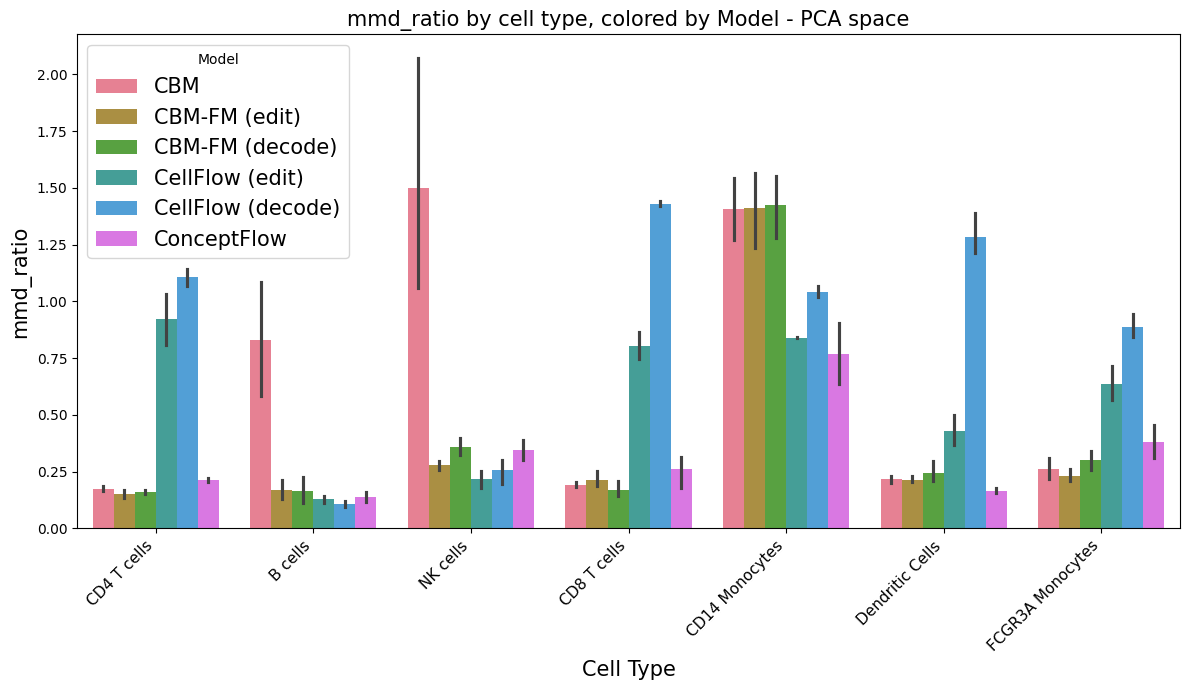

In [28]:
# Barplot: 4 bars for each cell type (one per model), aggregation over seeds, with error bars, larger font, and tilted x labels
import matplotlib.pyplot as plt
import seaborn as sns

# Check required columns
required_cols = ['data/intervention_labels', 'model', 'seed', metric_name]
missing = [col for col in required_cols if col not in df_res_sub.columns]
if missing:
    raise ValueError(f"Missing columns in df_res: {missing}")

# Aggregate over seeds: mean and std of mmd_ratio for each (cell type, model) pair
#plot_df = df_res_sub.groupby(['data/intervention_labels', 'model']).agg({'mmd_ratio': ['mean', 'std']}).reset_index()

plt.figure(figsize=(12,7))
ax = sns.barplot(
    data=df_res_sub,
    x='data/intervention_labels',
    y=metric_name,
    estimator="mean",
    hue='model',
    palette='husl',
 )

plt.title(f'{metric_name} by cell type, colored by Model - PCA space', fontsize=15)
plt.ylabel(f'{metric_name}', fontsize=15)
plt.xlabel('Cell Type', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.legend(title='Model', fontsize=15)
plt.tight_layout()
plt.show()

In [29]:
df_res_sub

,seed,model,data/intervention_labels,mmd_ratio,recall_negs,recall_pos,model.edit,recall_avg
0,13,CBM,CD4 T cells,0.170848,0.770833,0.970464,NaN,0.870649
1,42,CBM,CD4 T cells,0.182050,0.708333,0.966245,NaN,0.837289
2,1337,CBM,CD4 T cells,0.188008,0.716667,0.945148,NaN,0.830907
3,69,CBM,CD4 T cells,0.157913,0.725000,0.945148,NaN,0.835074
4,13,CBM,B cells,0.804415,0.514451,0.934911,NaN,0.724681
...,...,...,...,...,...,...,...,...
163,69,ConceptFlow,Dendritic Cells,0.185352,1.000000,0.942408,NaN,0.971204
164,13,ConceptFlow,FCGR3A Monocytes,0.322187,0.827586,0.903670,NaN,0.865628
165,42,ConceptFlow,FCGR3A Monocytes,0.400487,0.770115,0.912844,NaN,0.841479
166,1337,ConceptFlow,FCGR3A Monocytes,0.501108,0.770115,0.899083,NaN,0.834599


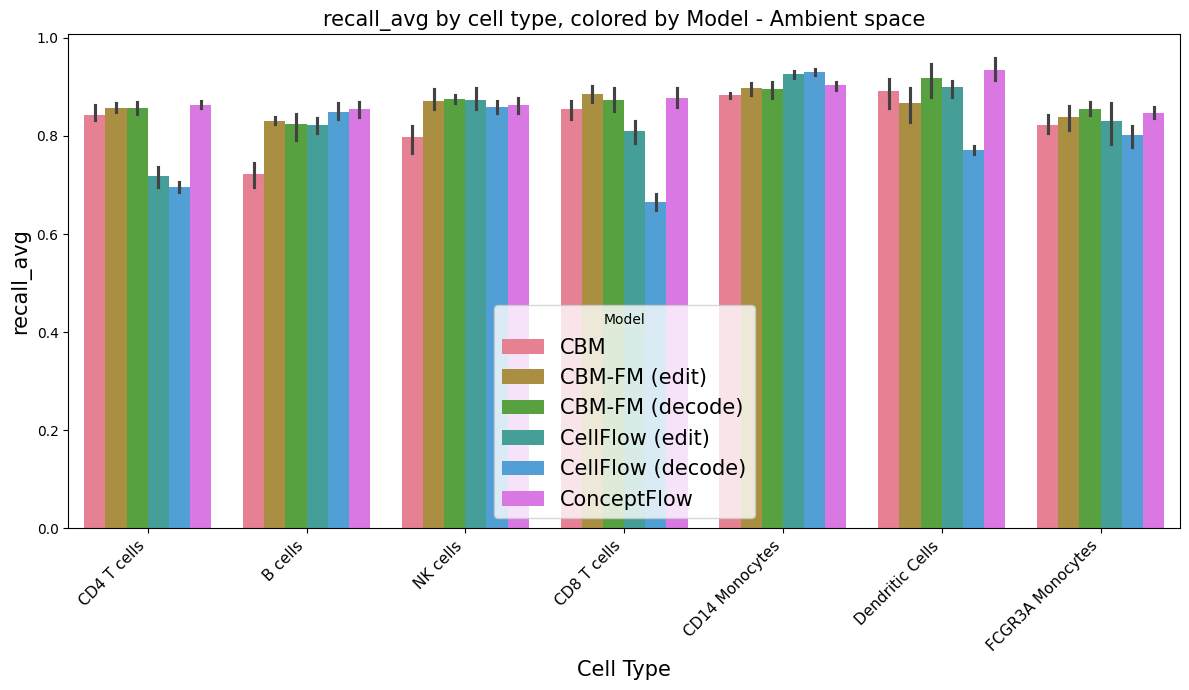

In [30]:
# Without PCA

metric_name = 'recall_avg'

# Check required columns
required_cols = ['data/intervention_labels', 'model', 'seed', 'mmd_ratio']
missing = [col for col in required_cols if col not in df_res_sub.columns]
if missing:
    raise ValueError(f"Missing columns in df_res: {missing}")

# Aggregate over seeds: mean and std of mmd_ratio for each (cell type, model) pair
plot_df = df_res_sub.groupby(['data/intervention_labels', 'model']).agg({'mmd_ratio': ['mean', 'std']}).reset_index()

plt.figure(figsize=(12,7))
ax = sns.barplot(
    data=df_res_sub,
    x='data/intervention_labels',
    y=metric_name,
    estimator="mean",
    hue='model',
    palette='husl',
 )

plt.title(f'{metric_name} by cell type, colored by Model - Ambient space', fontsize=15)
plt.ylabel(f'{metric_name}', fontsize=15)
plt.xlabel('Cell Type', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.legend(title='Model', fontsize=15)
plt.tight_layout()
plt.show()